<a href="https://colab.research.google.com/github/sujatasahoo/Predictive-Modeling_TreeBased-Model/blob/main/sujata_LS_DS_221_assignments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 2, Module 1*

---

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://www.kaggle.com/t/b57b60bbbbe146a687a9f468d0f928bf'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
    
# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Decision Trees

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump dataset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Kaggle

**Task 1:** [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. **We recommend that you choose a username that's based on your name, since you might include it in your resume in the future.** Go to our Kaggle InClass competition website (the URL is in Slack). Go to the **Rules** page. Accept the rules of the competition. Notice that the **Rules** page also has instructions for the Submission process. The **Data** page has feature definitions.

# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Task 1:** Using the `wrangle` function above, read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
train_features = pd.read_csv('/content/drive/MyDrive/WaterpumpDataset/train_features.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/WaterpumpDataset/train_labels.csv')
df = pd.merge(pd.read_csv('/content/drive/MyDrive/WaterpumpDataset/train_features.csv',na_values=[0,-2.000000e-08]),
                pd.read_csv('/content/drive/MyDrive/WaterpumpDataset/train_labels.csv', na_values=[0,-2.000000e-08]))
def wrangle(df):

  #set the index to 'id'
  df.set_index('id', inplace=True)

  # Drop Constant Column
  df.drop(columns='recorded_by', inplace=True)

  # Drop Duplicate Column
  df.drop(columns='quantity_group', inplace=True)

  # Drop High Cardinality Columns
  cols_to_drop = [col for col in df.select_dtypes('object') if df[col].nunique() > 100]
  df.drop(columns=cols_to_drop, inplace=True)

  # Drop columns with high proportion of null values
  df.drop(columns='num_private', inplace=True)


  return df

df = wrangle(df)

In [ ]:
df.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
510.0,NaN,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
14146.0,NaN,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional
47410.0,NaN,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
1288.0,300.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional


In [ ]:

X_test = pd.read_csv('/content/drive/MyDrive/WaterpumpDataset/test_features.csv')
X_test.head()
X_test = wrangle(X_test)
X_test.head()

,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
37098,0.0,0,31.985658,-3.596360,Lake Tanganyika,Shinyanga,17,5,0,True,WUG,True,0,other,other,other,wug,user-group,unknown,unknown,soft,good,dry,shallow well,shallow well,groundwater,other,other
14530,0.0,0,32.832815,-4.944937,Lake Tanganyika,Tabora,14,6,0,True,VWC,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,milky,milky,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
62607,10.0,1675,35.488289,-4.242048,Internal,Manyara,21,1,148,True,Water Board,True,2008,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
46053,0.0,0,33.140828,-9.059386,Lake Rukwa,Mbeya,12,6,0,False,VWC,False,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,seasonal,shallow well,shallow well,groundwater,hand pump,hand pump
47083,50.0,1109,34.217077,-4.430529,Internal,Singida,13,1,235,True,WUA,True,2011,mono,mono,motorpump,wua,user-group,pay per bucket,per bucket,soft,good,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [ ]:
target = 'status_group'
X = df.drop(columns = target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size= 0.2, random_state = 42)
X_train.shape

(38016, 28)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [ ]:
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5440867003367004


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_dt`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `DecisionTreeClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `DecisionTreeClassifier`.

In [ ]:
model_dt = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(random_state=42))


model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type',
                                      'waterpoin...
communal standpipe             2
communal standpipe multiple    3
other                          4
improved spring                5
cattle trough                  6
dam                            7
NaN                           -

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_dt`.

In [ ]:
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9952388468013468
Validation Accuracy Score: 0.748526936026936


# VI. Tune Model

**Task 8:** Is there a large difference between your training and validation accuracy? If so, experiment with different setting for `max_depth` in your `DecisionTreeClassifier` to reduce the amount of overfitting in your model.

In [ ]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6
depths = range(5, 15 , 2)
list(depths)

[5, 7, 9, 11, 13]

In [ ]:
train_acc = []
val_acc = []
for depth in depths:
  tree_model = make_pipeline(OrdinalEncoder(), 
                             SimpleImputer(), 
                             DecisionTreeClassifier(max_depth =depth, random_state = 42))
tree_model.fit(X_train, y_train)
train_acc.append(tree_model.score(X_train, y_train))
val_acc.append(tree_model.score(X_val, y_val))
train_acc


[0.8219170875420876]

In [ ]:
val_acc

[0.7570496632996633]

# VII. Communicate Results

**Task 9 `stretch goal`:** Create a horizontal barchart that shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values that are different from [`LogisticRegression.coef_`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). All the values will be positive, and they will sum to `1`.

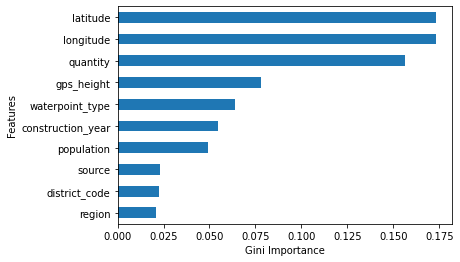

In [ ]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data = gini, index= features).sort_values(key = abs).tail(10).plot(kind ='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Features');